In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random
import statsmodels.api as sm

In [3]:
random.seed(760)

In [4]:
data=pd.read_csv('drive/MyDrive/clean_data.csv', encoding='utf-8')
def get_season(month): #春0夏1秋2冬3
    if 9 <= month <= 11:
        return "0"
    elif 12 <= month <= 2:
        return "1"
    elif 3 <= month <= 6:
        return "2"
    else:
        return "3"
data['Date'] = pd.to_datetime(data['Date'])
data['season'] = data['Date'].dt.month.apply(get_season)
grouped_data = data.groupby("Date")["Victimisations"].sum().reset_index()
grouped_data['season'] = data.groupby("Date")['season'].first().reset_index()['season']

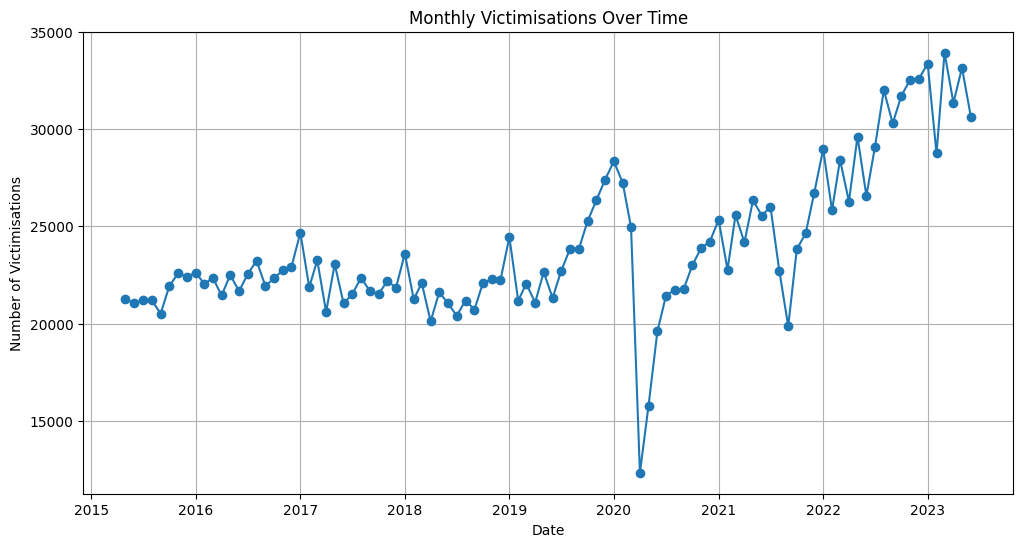

In [5]:
data_covid = pd.DataFrame(grouped_data)
data_covid['Date'] = pd.to_datetime(data_covid['Date'])
plt.figure(figsize=(12, 6))
plt.plot(data_covid['Date'], data_covid['Victimisations'], marker='o')
plt.title('Monthly Victimisations Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Victimisations')
plt.grid(True)
plt.show()

In [6]:
data_covid['pre_covid'] = (data_covid['Date'] < "2020-03-01").astype(int)
data_covid['during_covid'] = ((data_covid['Date'] >= "2020-03-01") & (data_covid['Date'] <= "2020-06-01")).astype(int)
data_covid['post_covid'] = (data_covid['Date'] > "2020-06-01").astype(int)
data_covid['time_pre_covid'] = data_covid.index * data_covid['pre_covid']
data_covid['time_during_covid'] = data_covid.index * data_covid['during_covid']
data_covid['time_post_covid'] = data_covid.index * data_covid['post_covid']
X = data_covid[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
X = sm.add_constant(X)
y = data_covid['Victimisations']
poisson_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
result = poisson_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Victimisations   No. Observations:                   98
Model:                            GLM   Df Residuals:                       92
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7869.3
Date:                Sat, 07 Oct 2023   Deviance:                       14571.
Time:                        05:49:25   Pearson chi2:                 1.43e+04
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.2871      0.04

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


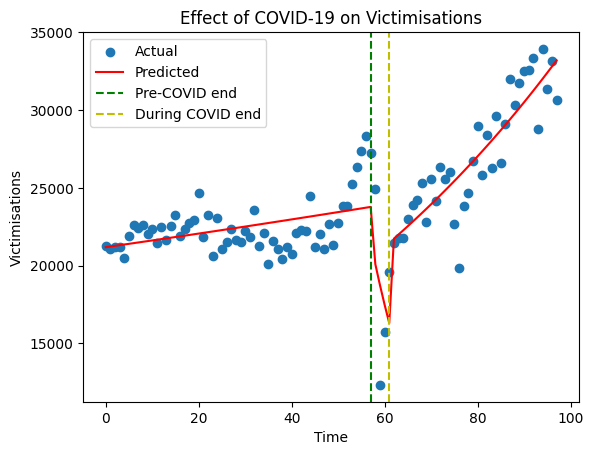

In [7]:
data_covid['predicted'] = result.predict(X)
time = np.arange(len(data_covid))
plt.scatter(time, data_covid['Victimisations'], label='Actual')
plt.plot(time, data_covid['predicted'], label='Predicted', color='red')
pre_covid_end = data_covid[data_covid['pre_covid'] == 1].index[-1]
during_covid_end = data_covid[data_covid['during_covid'] == 1].index[-1]
plt.axvline(x=pre_covid_end, color='g', linestyle='--', label='Pre-COVID end')
plt.axvline(x=during_covid_end, color='y', linestyle='--', label='During COVID end')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Victimisations')
plt.title('Effect of COVID-19 on Victimisations')
plt.show()

In [8]:
grouped_df = data.groupby(['Date', 'ANZSOC Division']).sum().reset_index()
final_df = grouped_df[['Date', 'ANZSOC Division', 'Victimisations']]

<ipython-input-8-a3ebafc5436e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = data.groupby(['Date', 'ANZSOC Division']).sum().reset_index()


In [9]:
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'])
grouped = grouped_df.groupby('ANZSOC Division')

for name, group in grouped:
    print(f"Analyzing for ANZSOC Division: {name}")
    group['pre_covid'] = (group['Date'] < "2020-03-01").astype(int)
    group['during_covid'] = ((group['Date'] >= "2020-03-01") & (group['Date'] <= "2020-06-01")).astype(int)
    group['post_covid'] = (group['Date'] > "2020-06-01").astype(int)
    group['time_pre_covid'] = (group['Date'].dt.year - 2015) * 12 + group['Date'].dt.month
    group['time_pre_covid'] *= group['pre_covid']

    group['time_during_covid'] = (group['Date'].dt.year - 2015) * 12 + group['Date'].dt.month
    group['time_during_covid'] *= group['during_covid']

    group['time_post_covid'] = (group['Date'].dt.year - 2015) * 12 + group['Date'].dt.month
    group['time_post_covid'] *= group['post_covid']
    X = group[['pre_covid', 'during_covid', 'post_covid', 'time_pre_covid', 'time_during_covid', 'time_post_covid']]
    X = sm.add_constant(X)
    y = group['Victimisations']
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
    result = poisson_model.fit()
    print(result.summary())


Analyzing for ANZSOC Division: Abduction, Harassment and Other Related Offences Against a Person
                 Generalized Linear Model Regression Results                  
Dep. Variable:         Victimisations   No. Observations:                   98
Model:                            GLM   Df Residuals:                       92
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -338.70
Date:                Sat, 07 Oct 2023   Deviance:                       151.20
Time:                        05:49:25   Pearson chi2:                     152.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3547
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The 